In [1]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize

In [2]:
# Load MNIST dataset
mnist_train = DataLoader(
    datasets.MNIST(
        root='./files/',
        train=True,
        download=True,
        transform=Compose([
            ToTensor(),
            Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=64,
    shuffle=True
)

mnist_test = DataLoader(
    datasets.MNIST(
        root='./files/',
        train=False,
        download=True,
        transform=Compose([
            ToTensor(),
            Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=64,
    shuffle=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.90MB/s]


In [3]:
examples = enumerate(mnist_test)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([64, 1, 28, 28])

Label: tensor(4)


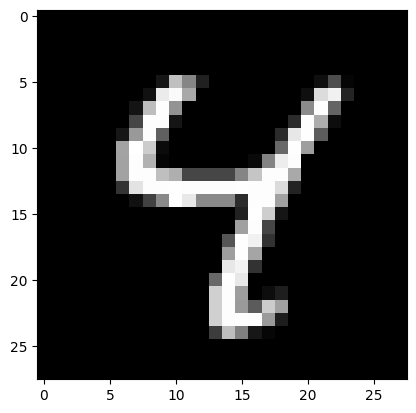

In [4]:
plt.imshow(example_data[6][0], cmap='gray')
print("Label:", example_targets[6])

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(mnist_train.dataset) for i in range(10)] # 10 is the number of epochs

In [8]:
import os

def train(epoch):
    model.train()
    # Create the directory if it doesn't exist
    if not os.path.exists('./files'):
        os.makedirs('./files')
    for batch_idx, (data, target) in enumerate(mnist_train):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(mnist_train.dataset),
                100. * batch_idx / len(mnist_train), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(mnist_train.dataset)))
            torch.save(model.state_dict(), './files/model.pth')
            torch.save(optimizer.state_dict(), './files/optimizer.pth')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in mnist_test:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(mnist_test.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(mnist_test.dataset),
        100. * correct / len(mnist_test.dataset)))

In [9]:
for epoch in range(10):
    train(epoch)
    test()

/tmp/ipython-input-161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.335522
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.295377
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.284080
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.242253
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.253443
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.243248
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.221611
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.222749
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.092915
Train Epoch: 0 [5760/60000 (10%)]	Loss: 1.968931
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.022048
Train Epoch: 0 [7040/60000 (12%)]	Loss: 1.826363
Train Epoch: 0 [7680/60000 (13%)]	Loss: 1.619836
Train Epoch: 0 [8320/60000 (14%)]	Loss: 1.564254
Train Epoch: 0 [8960/60000 (15%)]	Loss: 1.457634
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.326166
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.325074
Train Epoch: 0 [10880/60000 (18%)]	Loss: 1.315271
Train Epoch: 0 [11520/60000 (19%)]	Loss: 1.109011
Train Epoch: 0 [12160/60000 (20%)]	Loss: 1.160354
Train Epoch: 0 [12800/60000 (

/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1933, Accuracy: 9427/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.333630
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.603210
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.385388
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.490124
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.636135
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.306971
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.365681
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.380927
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.324595
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.366643
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.863663
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.272689
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.259877
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.507452
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.471831
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.503981
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.238012
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.483774
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.326580
Train Epoch: 1 [12160

Text(0, 0.5, 'negative log likelihood loss')

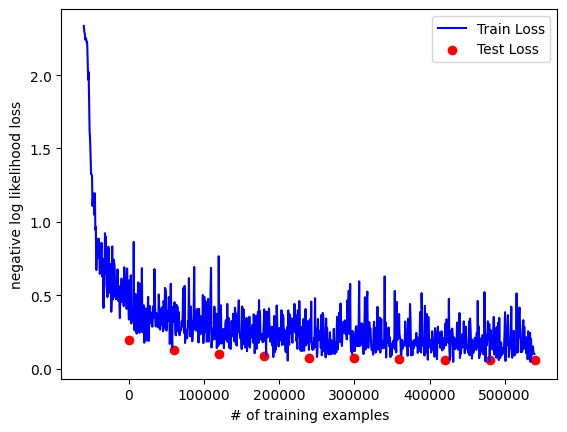

In [10]:
performance_plot = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('# of training examples')
plt.ylabel('negative log likelihood loss')